In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
def split_X_y(data):
    y = data.pop("rating_label")
    X = data
    return X, y

def transform_ratings(y, reduce):
    return y - 3 if reduce else y + 3

train = pd.read_csv('train_final_normalised.csv')
test = pd.read_csv('test_final_normalised.csv')
predict = pd.read_csv('predict_final_normalised.csv')

train_X, train_y = split_X_y(train)
test_X, test_y = split_X_y(test)
predict_X = predict

train_y = transform_ratings(train_y, reduce=True)
test_y = transform_ratings(test_y, reduce=True)

## Initial Model

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

svm_model = SVC(class_weight='balanced')
logistic_model = LogisticRegression(solver='lbfgs', max_iter=1000)
base_models = [('svm', svm_model), ('logistic', logistic_model)]
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
stacking_model.fit(train_X, train_y)

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

test_predictions = stacking_model.predict(test_X)
print("accuracy:", accuracy_score(test_y, test_predictions))
print("f1 score:", f1_score(test_y, test_predictions, average='macro'))

accuracy: 0.7027964448298287
f1 score: 0.30742843975246403


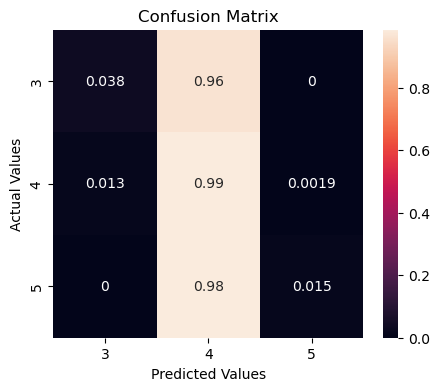

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_y, test_predictions)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm_df = pd.DataFrame(cmn,
                     index = ['3','4','5'], 
                     columns = ['3','4','5'])


plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## Hyperparameter Tuning

In [20]:
from sklearn.model_selection import RandomizedSearchCV

possible_hyperparams = {
    'svm__kernel': ['rbf', 'linear', 'poly'], 
    'svm__C': [5], 
    'svm__degree': [i for i in range(2, 15)],

    'logistic__penalty': ['l2', 'none'], 
    'logistic__C': [i for i in np.linspace(0.1, 6, 7)],

    'final_estimator__penalty': ['l2', 'none'],
    'final_estimator__C': [i for i in np.linspace(0.1, 6, 7)],
}

svm_model = SVC(class_weight='balanced')
logistic_model = LogisticRegression(solver='lbfgs', max_iter=1000)
base_models = [('svm', svm_model), ('logistic', logistic_model)]
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

rand_search = RandomizedSearchCV(stacking_model, possible_hyperparams, cv=5, scoring='f1_macro', n_iter=10)
rand_search.fit(train_X, train_y)
rand_search_results = pd.DataFrame(rand_search.cv_results_)

/Users/matthewcho/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/matthewcho/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/matthewcho/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/matthewcho/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/matthewcho/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/matthewcho/opt/ana

In [21]:
rand_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__kernel,param_svm__degree,param_svm__C,param_logistic__penalty,param_logistic__C,param_final_estimator__penalty,param_final_estimator__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1775.929857,21.097267,2.729341,0.039672,linear,7,5,none,5.016667,l2,6.0,"{'svm__kernel': 'linear', 'svm__degree': 7, 's...",0.309385,0.334141,0.319371,0.291512,0.326840,0.316250,0.014840,7
1,1733.046452,23.429842,2.726961,0.037239,linear,13,5,none,3.05,none,3.05,"{'svm__kernel': 'linear', 'svm__degree': 13, '...",0.309385,0.334723,0.319371,0.291360,0.326840,0.316336,0.015031,6
2,252.985814,1.813324,6.756752,0.025290,rbf,6,5,none,5.016667,l2,5.016667,"{'svm__kernel': 'rbf', 'svm__degree': 6, 'svm_...",0.327732,0.343747,0.334944,0.312452,0.342459,0.332267,0.011455,3
3,242.143844,1.775836,6.760180,0.024324,rbf,8,5,l2,3.05,none,0.1,"{'svm__kernel': 'rbf', 'svm__degree': 8, 'svm_...",0.327637,0.344857,0.335713,0.309445,0.346071,0.332744,0.013432,2
4,1703.882157,16.288546,2.729565,0.038515,linear,6,5,l2,5.016667,none,0.1,"{'svm__kernel': 'linear', 'svm__degree': 6, 's...",0.309385,0.334050,0.319371,0.291360,0.326221,0.316077,0.014781,9
5,1703.351291,11.830290,2.721709,0.015082,linear,6,5,l2,6.0,none,3.05,"{'svm__kernel': 'linear', 'svm__degree': 6, 's...",0.309385,0.334050,0.318758,0.291360,0.326840,0.316079,0.014844,8
6,1713.532238,18.518109,2.725999,0.025391,linear,11,5,l2,5.016667,l2,4.033333,"{'svm__kernel': 'linear', 'svm__degree': 11, '...",0.309385,0.333557,0.318758,0.290802,0.326221,0.315745,0.014824,10
7,250.644946,6.178580,3.259731,0.015829,poly,8,5,l2,4.033333,none,0.1,"{'svm__kernel': 'poly', 'svm__degree': 8, 'svm...",0.315401,0.344483,0.330142,0.299956,0.333148,0.324626,0.015434,5
8,256.398507,6.631412,6.819748,0.068159,rbf,3,5,none,5.016667,none,0.1,"{'svm__kernel': 'rbf', 'svm__degree': 3, 'svm_...",0.327162,0.343846,0.341201,0.310567,0.341852,0.332926,0.012653,1
9,256.634286,5.109661,3.187610,0.015437,poly,7,5,l2,3.05,none,2.066667,"{'svm__kernel': 'poly', 'svm__degree': 7, 'svm...",0.317418,0.340126,0.330824,0.300041,0.336766,0.325035,0.014708,4


In [23]:
rand_search.best_params_

{'svm__kernel': 'rbf',
 'svm__degree': 3,
 'svm__C': 5,
 'logistic__penalty': 'none',
 'logistic__C': 5.016666666666667,
 'final_estimator__penalty': 'none',
 'final_estimator__C': 0.1}

In [31]:
possible_hyperparams = {
    'svm__kernel': ['rbf', 'linear', 'poly'], 
    'svm__C': [5], 
    'svm__degree': [i for i in range(2, 15)],

    'logistic__penalty': ['l2', 'none'], 
    'logistic__C': [i for i in np.linspace(0.1, 6, 7)],

    'final_estimator__penalty': ['l2', 'none'],
    'final_estimator__C': [i for i in np.linspace(0.1, 6, 7)],
}

final_svm_model = SVC(class_weight='balanced', kernel='rbf', degree=3, C=5)
final_logistic_model = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='none', C=5.02)
final_base_models = [('svm', svm_model), ('logistic', logistic_model)]
final_stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(solver='lbfgs', max_iter=1000, penalty='none', C=0.1))

In [32]:
final_stacking_model.fit(train_X, train_y)

/Users/matthewcho/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


StackingClassifier(estimators=[('svm', SVC(class_weight='balanced')),
                               ('logistic', LogisticRegression(max_iter=1000))],
                   final_estimator=LogisticRegression(C=0.1, max_iter=1000,
                                                      penalty='none'))

In [33]:
final_test_predictions = final_stacking_model.predict(test_X)
print("accuracy:", accuracy_score(test_y, final_test_predictions))
print("f1 score:", f1_score(test_y, final_test_predictions, average='macro'))

accuracy: 0.7032300021677866
f1 score: 0.3137863107593655


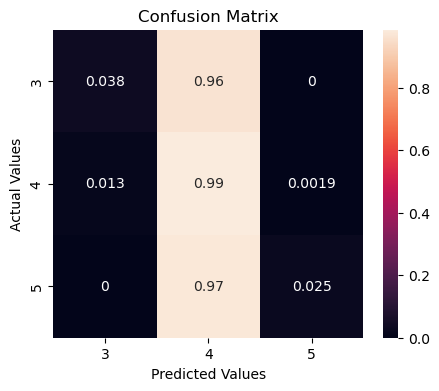

In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_y, final_test_predictions)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm_df = pd.DataFrame(cmn,
                     index = ['3','4','5'], 
                     columns = ['3','4','5'])


plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [35]:
predictions = final_stacking_model.predict(predict_X)
predictions = np.array(predictions) + 3
output = pd.DataFrame({
    "id": range(1, len(predictions) + 1),
    "rating_label": predictions
})
output.to_csv("stacking_output.csv", index=False)